In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import statistics
from scipy.stats import pearsonr
import seaborn as sns

import sys
import os

# Use os.getcwd() to get the current working directory if __file__ is not available
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

# Now you can import the necessary modules from the parent directory
from RADARDataCapture import FMCWRADARDataCapture
from MOCAPDataCapture import MOCAPDataCapture
from FPDataCapture import FPDataCapture

In [25]:
import pandas as pd
import numpy as np

# Path to the CSV file containing time labels
fp_mocap_comparison_df_path = '/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/MOCAP_FP_RADAR_FU_Stable_Break_FD_TIME_FRAMES_v3.csv'
fp_mocap_comparison_df = pd.read_csv(fp_mocap_comparison_df_path)

print(fp_mocap_comparison_df.head())

problem_list = []
statistics = {}  # To store summary stats per participant

for index, row in fp_mocap_comparison_df.iterrows():
    capture_name = row['RADAR_capture']

    participant = capture_name[:2]
    # if participant != "24" and participant != "15":  # Only analyzing participants 24 and 15
    #     continue

    radar_file_path = f"/Volumes/FourTBLaCie/Yoga_Study_RADAR_Data_Renamed/{participant}/{capture_name}.h5"

    # Handle special cases to skip certain captures or transitions
    if capture_name == '22_MNTRL_RR_V1' and str(row['tx']) == "3":
        continue
    elif capture_name == '24_MNTRR_RR_V1' and str(row['tx']) == "2":
        continue
    elif capture_name == '12_MNTRR_RR_V1':
        continue

    
    try:
        # Initialize the FMCWRADARDataCapture object
        RADAR_object = FMCWRADARDataCapture(file_path=radar_file_path)
    except Exception as e:
        problem_list.append((capture_name, row['tx'], e))
        continue

    # Load the data
    dataCubes = RADAR_object.load_and_save()

    # Select frames between frame_stable and frame_end
    frame_stable = int(row['frame_stable'])
    if row['is_final_tx']:
        frame_end = int(row['frame_end'])
    else:
        frame_end = int(row['frame_break'])

    dataCubes_stable = dataCubes[:, frame_stable:frame_end, :, :]

    range_bins_of_interest = [7]

    # Compute the unwrapped phases or displacement
    displacements = RADAR_object.unwrapped_microdoppler_phase_displacement(
        capture_name=capture_name,
        tx = row['tx'],
        dataCubes=dataCubes_stable,
        range_bins=range_bins_of_interest,
        plot=False  # We don't need to plot for every iteration
    ) 
    
    # Compute summary statistics for each channel and range bin
    for channel in displacements:
        for range_bin in displacements[channel]:
            t, displacement = displacements[channel][range_bin]

            # Compute summary statistics
            displacement_mean = np.mean(displacement)
            displacement_std = np.std(displacement)
            displacement_range = np.ptp(displacement)  # Peak-to-peak (max - min)
            displacement_max = np.max(displacement)
            displacement_min = np.min(displacement)

            # Print the stats for the current channel, range bin, and participant
            print(f"Participant: {participant}, Capture: {capture_name}, Channel: {channel}, Range Bin: {range_bin}")
            print(f"Mean Displacement: {displacement_mean:.6f} m")
            print(f"Std Deviation: {displacement_std:.6f} m")
            print(f"Range (Peak-to-Peak): {displacement_range:.6f} m")
            print(f"Max Displacement: {displacement_max:.6f} m, Min Displacement: {displacement_min:.6f} m")
            print("-" * 50)

            # Save the statistics for further analysis
            if participant not in statistics:
                statistics[participant] = []

            statistics[participant].append({
                'capture_name': capture_name,
                'tx': row['tx'],
                'channel': channel,
                'range_bin': range_bin,
                'mean_displacement': displacement_mean,
                'std_deviation': displacement_std,
                'range_displacement': displacement_range,
                'max_displacement': displacement_max,
                'min_displacement': displacement_min
            })

# Convert the statistics into a DataFrame for further analysis
wobble_stats_df = pd.DataFrame([
    {'participant': participant, **stat} for participant, stats_list in statistics.items() for stat in stats_list
])

print(wobble_stats_df)


    RADAR_capture  MOCAP_Start_Time  MOCAP_End_Time  RADAR_Start_Frame  \
0  01_MNTRL_RR_V1              7.33           30.57                194   
1  01_MNTRL_RR_V1              7.33           30.57                194   
2  01_MNTRL_RR_V1              7.33           30.57                194   
3  01_MNTRL_RR_V2              7.37           30.40                191   
4  01_MNTRL_RR_V2              7.37           30.40                191   

   RADAR_End_Frame  Seconds_per_Frame  tx  is_final_tx  t_foot_up  t_stable  \
0              831            0.03645   1        False      10.22     11.19   
1              831            0.03645   2        False      18.25     19.05   
2              831            0.03645   3         True      26.24     27.03   
3              822            0.03646   1        False      10.48     11.05   
4              822            0.03646   2        False      18.41     19.07   

   t_break  t_foot_down  frame_foot_up  frame_stable  frame_break  frame_end  
0

In [26]:
wobble_stats_df.head

<bound method NDFrame.head of      participant    capture_name  tx  channel  range_bin  mean_displacement  \
0             01  01_MNTRL_RR_V1   1        0          7          -0.001816   
1             01  01_MNTRL_RR_V1   1        1          7          -0.001006   
2             01  01_MNTRL_RR_V1   1        2          7          -0.001522   
3             01  01_MNTRL_RR_V1   1        3          7          -0.001663   
4             01  01_MNTRL_RR_V1   2        0          7           0.005302   
...          ...             ...  ..      ...        ...                ...   
1059          24  24_MNTRR_RR_V3   2        3          7          -0.000725   
1060          24  24_MNTRR_RR_V3   3        0          7           0.000482   
1061          24  24_MNTRR_RR_V3   3        1          7          -0.003097   
1062          24  24_MNTRR_RR_V3   3        2          7           0.001978   
1063          24  24_MNTRR_RR_V3   3        3          7           0.001084   

      std_deviation  

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'wobble_stats_df' contains radar wobble statistics
# and we already have 'COP velocity squared' data stored per capture

# Initialize a list to store combined data for plotting
combined_data = []

# Iterate over the comparison DataFrame (from force plate and radar data)
for index, row in fp_mocap_comparison_df.iterrows():
    
    # Extract participant and capture names
    participant = row['RADAR_capture'][:2]
    MOCAP_capture_name = row['RADAR_capture'].replace('_RR_', '_MC_')
    base_file_path = f"/Volumes/FourTBLaCie/Yoga_Study_FP_1and2_MNTR/{participant}/{MOCAP_capture_name}.tsv"

    # Load COP data
    force_plate_capture = FPDataCapture(base_file_path)
    
    if MOCAP_capture_name == '22_MNTRL_MC_V1' and str(row['tx']) == "3":
        continue
    elif MOCAP_capture_name == '24_MNTRR_MC_V1' and str(row['tx']) == "2":
        continue
    elif MOCAP_capture_name == '12_MNTRR_MC_V1':
        continue
    elif MOCAP_capture_name == '16_MNTRL_MC_V2' and str(row['tx']) == '3':
        continue
    
    # Select the correct COP data based on MNTRL or MNTRR
    if "MNTRR" in force_plate_capture.base_file_path:
        cop_data = force_plate_capture.data_f_1
    elif "MNTRL" in force_plate_capture.base_file_path:
        cop_data = force_plate_capture.data_f_2
    else:
        print(f"Unknown base file path format for sample {index}.")
        continue
    
    if row['is_final_tx']:
        t_start = row['t_stable']
        t_end = row['t_foot_down']
    else:
        t_start = row['t_stable']
        t_end = row['t_break']
    
    # Extract COP data for the relevant time interval
    cop_data_interval = cop_data[(cop_data['time'] >= t_start) & (cop_data['time'] <= t_end)]

    print(cop_data_interval)
    
    # Calculate the differences in time and COP positions
    cop_x = cop_data_interval['COP_X'].values
    cop_y = cop_data_interval['COP_Y'].values
    time = cop_data_interval['time'].values

    # Calculate differences between consecutive COP values and time
    delta_x = np.diff(cop_x)
    delta_y = np.diff(cop_y)
    delta_time = np.diff(time)

    # Calculate the COP speed at each time step (displacement / time)
    cop_speed = np.sqrt(delta_x**2 + delta_y**2) / delta_time

    # Optionally calculate the square of the COP speed for further analysis
    cop_velocity_squared = np.mean(cop_speed**2)


    # Find corresponding radar displacement data
    radar_capture = row['RADAR_capture']
    radar_entry = wobble_stats_df[(wobble_stats_df['capture_name'] == radar_capture) & (wobble_stats_df['tx'] == row['tx'])]
    
    if radar_entry.empty:
        print(f"No radar data found for capture {radar_capture}. Skipping.")
        continue


    # Extract the std deviation of displacement for each of the 4 channels
    for channel in range(4):
        radar_entry_channel = radar_entry[radar_entry['channel'] == channel]
        
        if radar_entry_channel.empty:
            print(f"No data found for channel {channel} in capture {radar_capture}. Skipping.")
            continue

        # Extract the std deviation for this channel
        radar_std_deviation = radar_entry_channel['std_deviation'].values[0]

        # Store the data for this specific channel
        combined_data.append({
            'participant': participant,
            'capture_name': radar_capture,
            'tx': row['tx'],
            'channel': channel,
            'cop_velocity_squared': cop_velocity_squared,
            'radar_std_deviation': radar_std_deviation
        })

# Convert combined data into a DataFrame
combined_df = pd.DataFrame(combined_data)

# Print the first few rows for debugging
print(combined_df.head())

# Plotting the scatter plot for individual channels
plt.figure(figsize=(10, 6))
sns.scatterplot(x='cop_velocity_squared', y='radar_std_deviation', hue='participant', style='channel', data=combined_df)
plt.title('Scatter Plot of COP Velocity^2 vs Radar Displacement Std Deviation (Individual Channels)')
plt.xlabel('COP Velocity^2 (mm^2/s^2)')
plt.ylabel('Radar Displacement Std Deviation (m)')
plt.grid(True)
plt.tight_layout()
plt.show()

       SAMPLE      time   Force_X   Force_Y     Force_Z   Moment_X   Moment_Y  \
13428   13429  11.19000 -9.536743 -4.653931  566.262245  28.793907 -45.441437   
13429   13430  11.19083 -9.536743 -4.653931  565.346718  28.977013 -45.441437   
13430   13431  11.19167 -9.689331 -5.264282  566.262245  28.336143 -45.502472   
13431   13432  11.19250 -9.384155 -4.806519  565.651894  28.793907 -45.258331   
13432   13433  11.19333 -9.231567 -4.501343  565.957069  28.702354 -45.563507   
...       ...       ...       ...       ...         ...        ...        ...   
17132   17133  14.27667 -3.585815 -8.010864  542.763710  30.624962 -47.760773   
17133   17134  14.27750 -3.738403 -8.621216  542.153358  30.441856 -47.699738   
17134   17135  14.27833 -3.738403 -8.468628  542.458534  30.533409 -47.943878   
17135   17136  14.27917 -4.043579 -8.010864  542.153358  30.716515 -47.821808   
17136   17137  14.28000 -4.043579 -8.926392  542.458534  30.624962 -47.821808   

        Moment_Z      COP_X

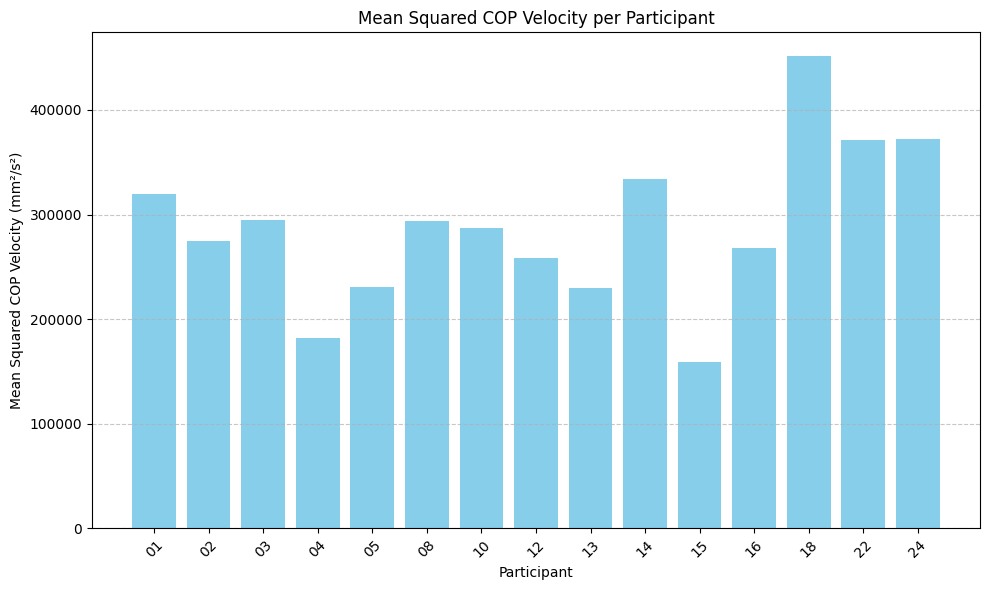

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `combined_df` is the merged DataFrame that contains participant and cop_velocity_squared columns
# combined_df = pd.merge(cop_velocity_df, radar_displacement_df, on=['participant', 'capture_name', 'tx'])

# Sort the DataFrame by participant for better visualization
combined_df_sorted = combined_df.sort_values(by='participant')

# Plot COP velocity squared for each participant
plt.figure(figsize=(10, 6))
plt.bar(combined_df_sorted['participant'], combined_df_sorted['cop_velocity_squared'], color='skyblue')
plt.xlabel('Participant')
plt.ylabel('Mean Squared COP Velocity (mm²/s²)')
plt.title('Mean Squared COP Velocity per Participant')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


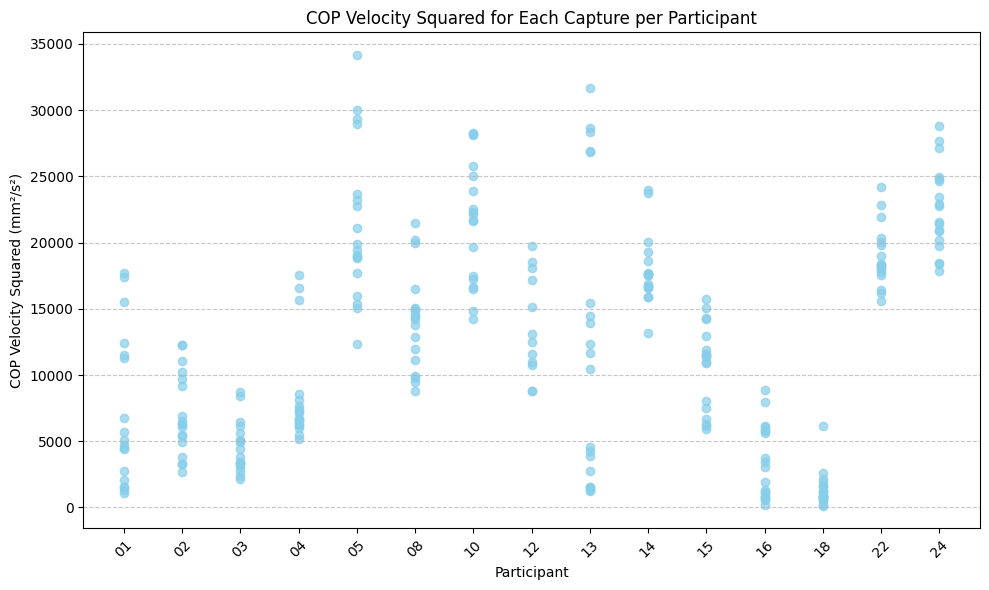

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `combined_df` is the DataFrame that contains participant and cop_velocity_squared for each capture
# combined_df = pd.merge(cop_velocity_df, radar_displacement_df, on=['participant', 'capture_name', 'tx'])

# Sort the DataFrame by participant for better visualization
combined_df_sorted = combined_df.sort_values(by='participant')

# Create a scatter plot to visualize all captures per participant
plt.figure(figsize=(10, 6))
plt.scatter(combined_df_sorted['participant'], combined_df_sorted['cop_velocity_squared'], color='skyblue', alpha=0.7)
plt.xlabel('Participant')
plt.ylabel('COP Velocity Squared (mm²/s²)')
plt.title('COP Velocity Squared for Each Capture per Participant')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
